Snapshots of daily averages (between day 1 and day 15) of U, V, and W velocities. Plots can be set for different depths. To be used in conjunction with animations_velocities_depths.ipynb

In [4]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from salishsea_tools.nc_tools import scDataset

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

%matplotlib inline

In [5]:
def get_files(dirname, fname, grid):
    files = []    
    for item in os.listdir(dirname):
        if fnmatch.fnmatchcase(item, fname + grid + "*.nc"):
            files += [os.path.join(dirname, item)]
    files.sort(key=os.path.basename)
    return files

In [6]:
def vel_timeseries(dirname, fname, dep_ind):
    
    filesU = get_files(dirname, fname, 'grid_U')        
    filesV = get_files(dirname, fname, 'grid_V')
    filesW = get_files(dirname, fname, 'grid_W')
    print('files')
    
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(filesU) as dsU, scDataset(filesV) as dsV, scDataset(filesW) as dsW:
        vozocrtx0 = dsU.variables['vozocrtx'][:,dep_ind,y,x]
        print('U')
        vomecrty0 = dsV.variables['vomecrty'][:,dep_ind,y,x]
        print('V')
        vovecrtz0 = dsW.variables['vovecrtz'][:,dep_ind,y,x]
        print('W')
        sozotaux = dsU.variables['sozotaux'][:,0,0]
        sometauy = dsV.variables['sometauy'][:,0,0]
        depthu = dsU.variables['depthu'][:]

    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,dep_ind,y,x]
        vmask0 = dsM.variables['vmask'][0,dep_ind,y,x]
        tmask0 = dsM.variables['tmask'][0,dep_ind,y,x]

    umask = np.tile(umask0, (len(sozotaux), 1, 1))
    vmask = np.tile(vmask0, (len(sozotaux), 1, 1))
    tmask = np.tile(tmask0, (len(sozotaux), 1, 1))

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    vovecrtz = np.ma.array(vovecrtz0, mask=1 - tmask)
    
    return vozocrtx, vomecrty, vovecrtz, umask, vmask, tmask, depthu

In [7]:
def get_speeds(U_vel, V_vel, dep, time_ind, arrow):
    '''This function unstaggers the velocity components
    and calculates the speeds at arrow intervals.
    
    #from /ocean/imachuca/Canyons/mackenzie_canyon/tools/functions_velocity.py
    '''
    ugrid = U_vel[time_ind, dep, :, :]
    vgrid = V_vel[time_ind, dep, :, :]
    u_nstg0 = (np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2)[..., 1:, :]
    v_nstg0 = (np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2)[..., 1:]
    u_nstg = u_nstg0[::arrow,::arrow]
    v_nstg = v_nstg0[::arrow,::arrow]
    x_slice = np.arange(1, ugrid.shape[1])[::arrow]
    y_slice = np.arange(1, ugrid.shape[0])[::arrow]
    speeds = np.sqrt(u_nstg**2 + v_nstg**2)
    return speeds

In [8]:
def get_1day_avg(vel, day_start, day_end):
    day = slice(day_start*24, day_end*24, None)
    vel_day = np.mean(vel[day, ...], axis=0)
    return vel_day

In [9]:
def plot_vel_snapshots(vel_all, xs, ys, vm, ttl):
    cmap = plt.get_cmap(cmo.cm.balance)
    cmap.set_bad('wheat')
    fig, axes = plt.subplots(3, 5, figsize=(20,15), sharey=True)
    for ax, n in zip(axes.flatten(), np.arange(15)):
        vel_dayn = get_1day_avg(vel_all, n, n+1)
        p = ax.pcolormesh(xs, ys, vel_dayn, vmin=-1*vm, vmax=vm, cmap=cmap)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_xlim([0, xs[-1]])
        ax.set_ylim([0, ys[-1]])
        ax.set_title('Day '+str(n+1), fontsize=16)
        if n==0:
            fig.colorbar(p, ax=ax)
    fig.tight_layout(w_pad=0.1, h_pad=0.25)
    fig.suptitle(ttl+' Profile at Depth '+str(np.round(depthu[dep_ind],1))+' m', fontsize=20)
    plt.subplots_adjust(top=0.92)
    return fig

In [10]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'
fname = "1_MCKNZ_1h_20170101_20170120_*"

 depthu = 4.375, 13.125, 21.875, 30.625, 39.375, 48.125, 56.875, 65.625, 
    74.375, 83.125, 91.875, 100.625, 109.375, 118.125, 126.875, 135.625, 
    144.375, 153.125, 161.875, 170.625, 179.375, 188.125, 196.875, 205.625, 
    214.375, 223.125, 231.875, 240.625, 249.375, 258.125, 266.875, 275.625, 
    284.375, 293.125, 301.875, 310.625, 319.375, 328.125, 336.875, 345.625, 
    354.375, 363.125, 371.875, 380.625, 389.375, 398.125, 406.875, 415.625, 
    424.375, 433.125, 441.875, 450.625, 459.375, 468.125, 476.875, 485.6253, 
    494.3771, 503.1404, 511.9886, 521.4466, 534.6722, 560.3319, 598.4258, 
    640.2872, 682.7585, 725.3146, 767.8822, 810.4514, 853.0208, 895.5903, 
    938.1597, 980.7292, 1023.299, 1065.868, 1108.438, 1151.007, 1193.576, 
    1236.146, 1278.715, 1321.285 ;


In [24]:
dep_inds = [9, 12, 18]

# First Depth

In [12]:
dep_ind = dep_inds[0]
vozocrtxA, vomecrtyA, vovecrtzA, umask, vmask, tmask, depthu = vel_timeseries(dirname, fname, dep_ind)
xs = np.arange(vozocrtxA.shape[-1])
ys = np.arange(vozocrtxA.shape[-2])

files
U
V
W


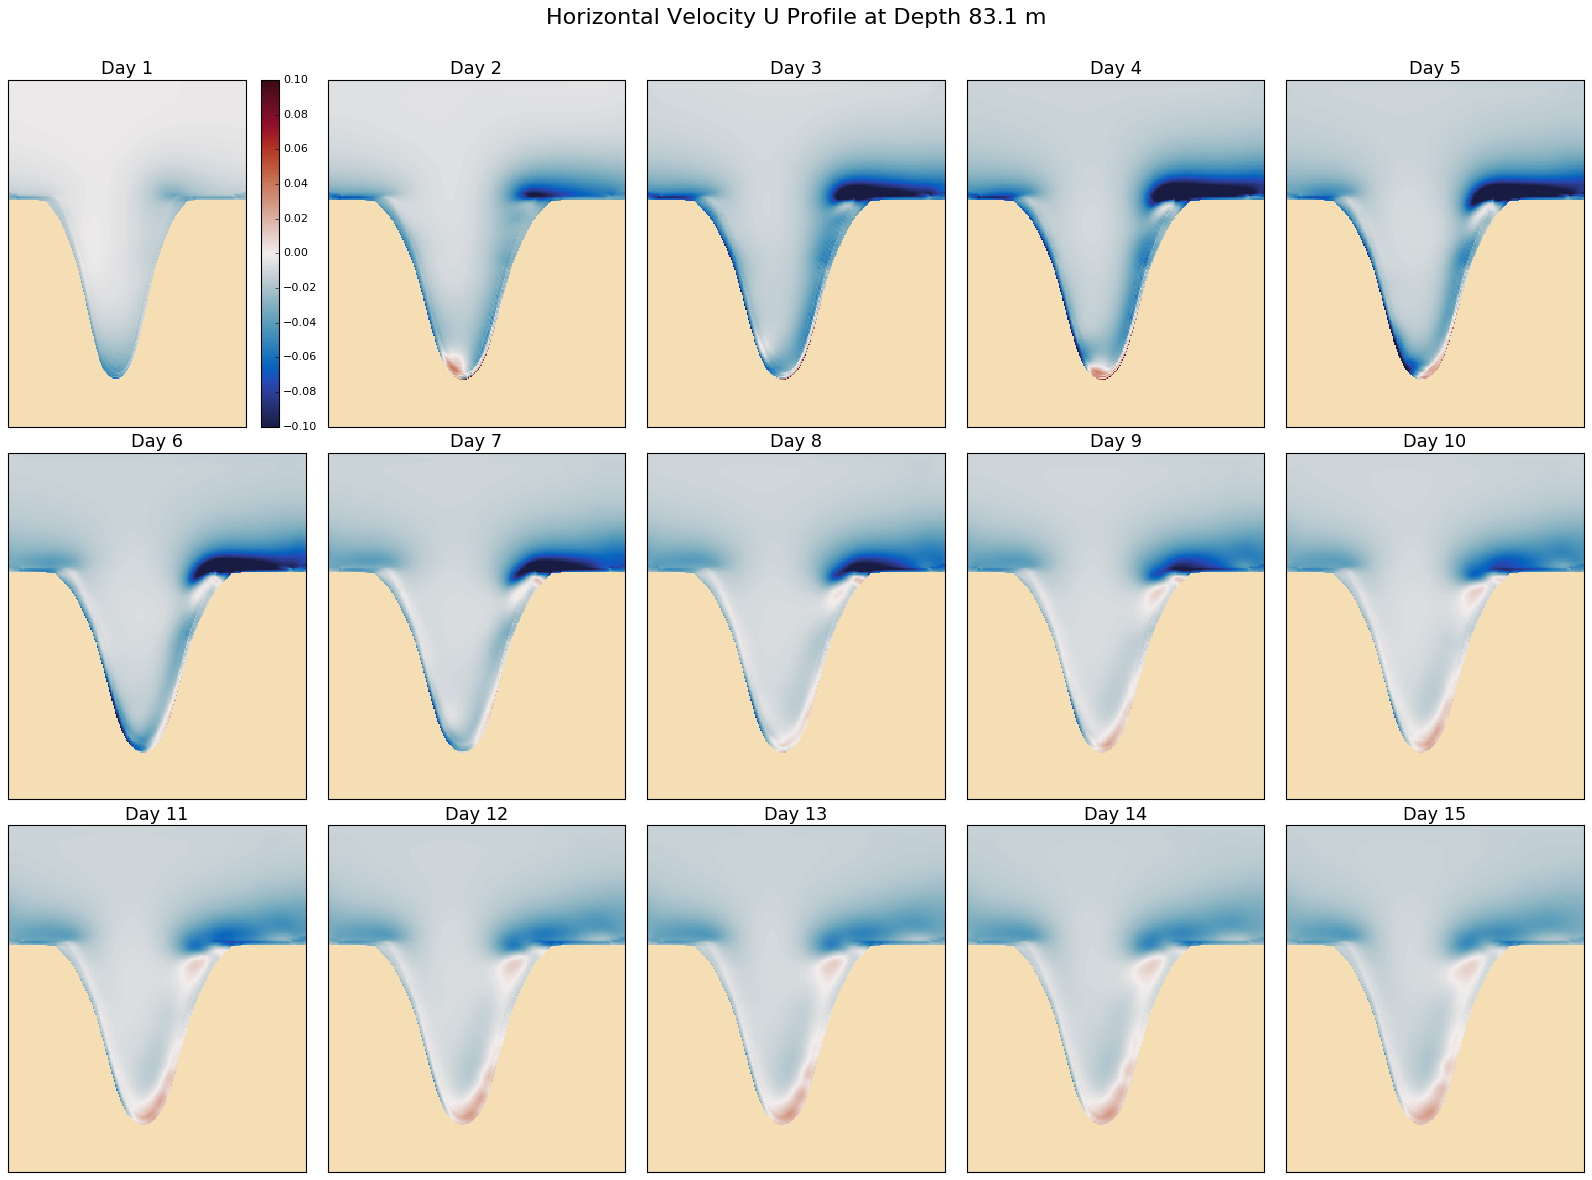

In [13]:
fig = plot_vel_snapshots(vozocrtxA, xs, ys, 0.1, 'Horizontal Velocity U')

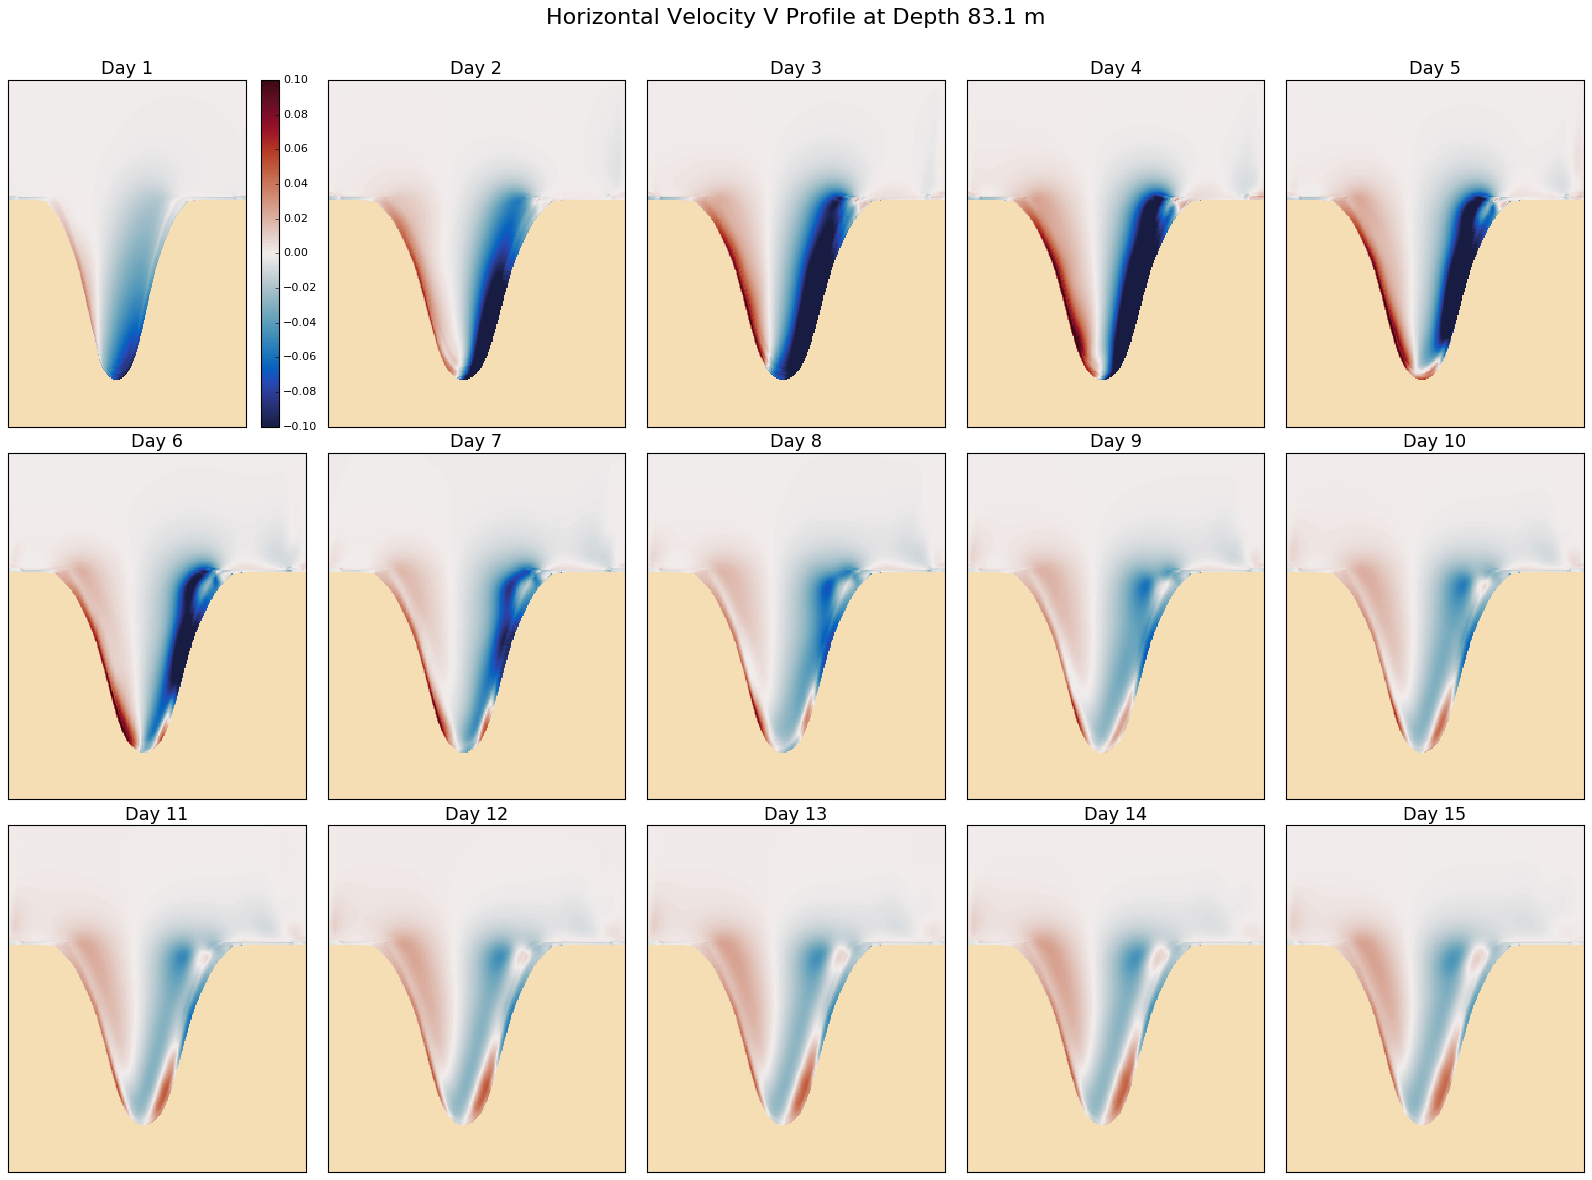

In [14]:
fig = plot_vel_snapshots(vomecrtyA, xs, ys, 0.1, 'Horizontal Velocity V')

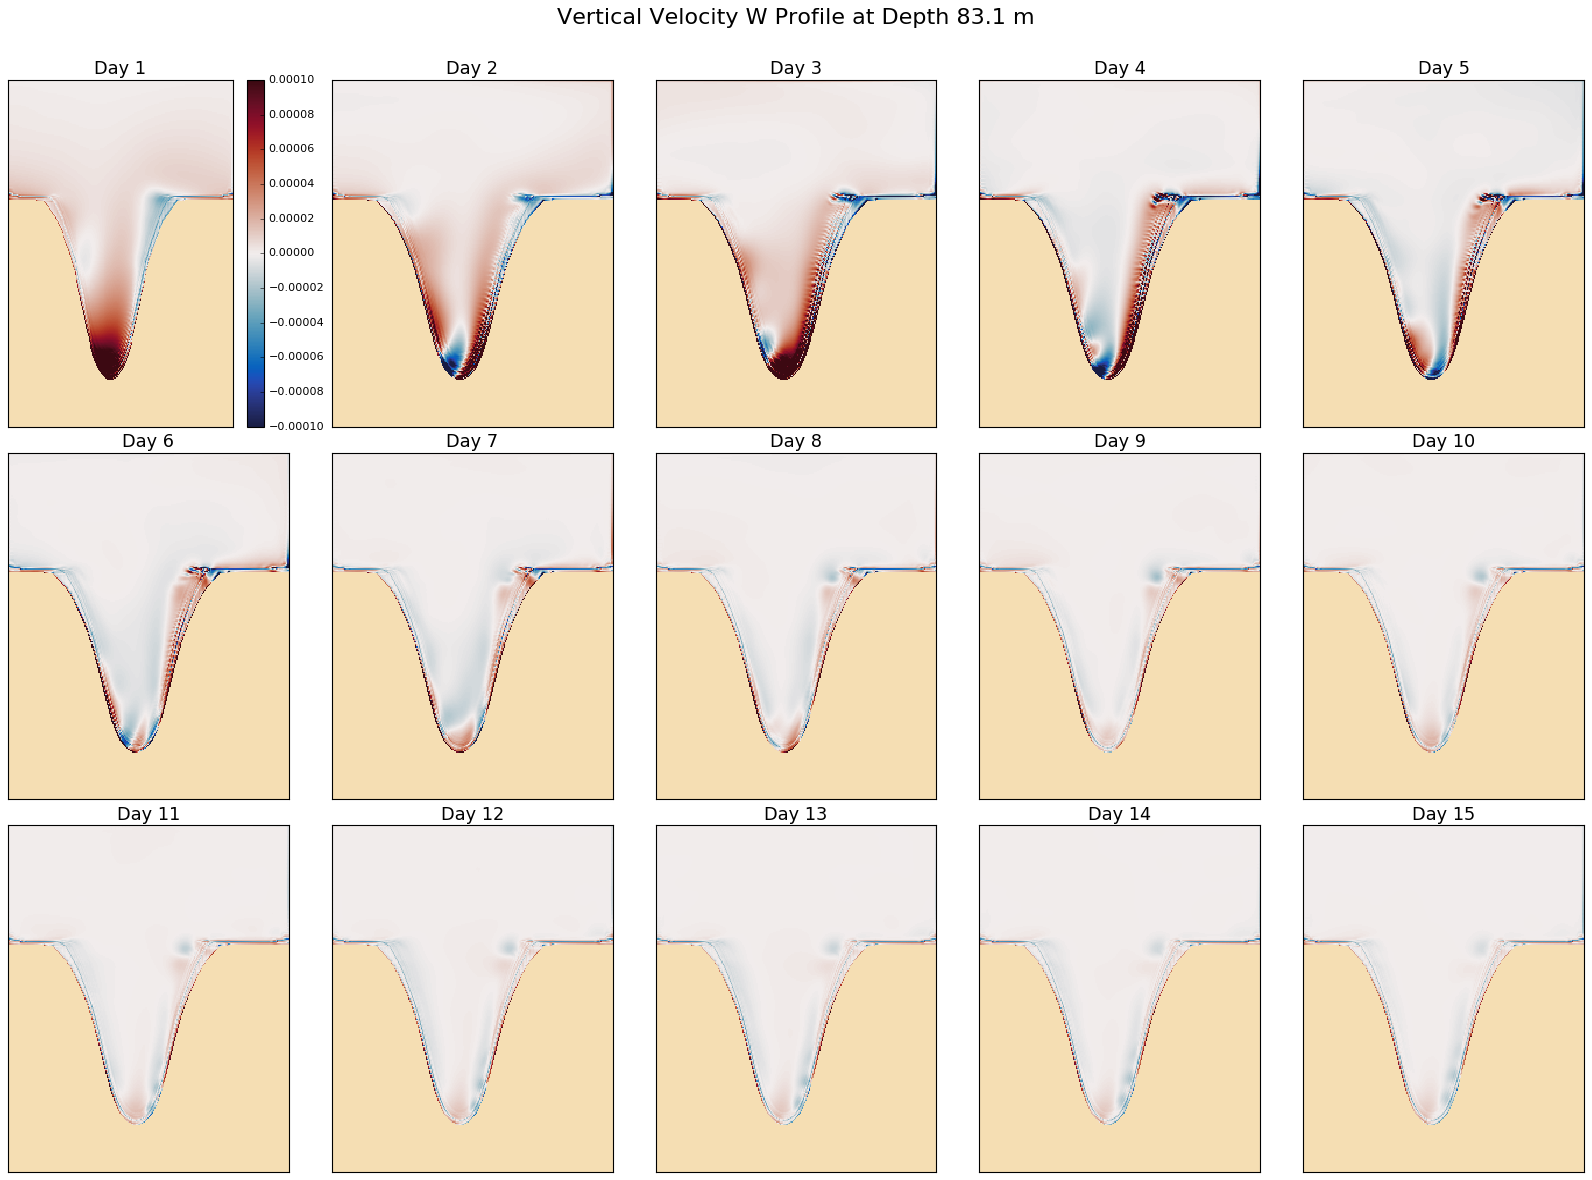

In [15]:
fig = plot_vel_snapshots(vovecrtzA, xs, ys, 0.0001, 'Vertical Velocity W')

# Second Depth

In [25]:
dep_ind = dep_inds[1]
vozocrtxB, vomecrtyB, vovecrtzB, umask, vmask, tmask, depthu = vel_timeseries(dirname, fname, dep_ind)
xs = np.arange(vozocrtxB.shape[-1])
ys = np.arange(vozocrtxB.shape[-2])

files
U
V
W


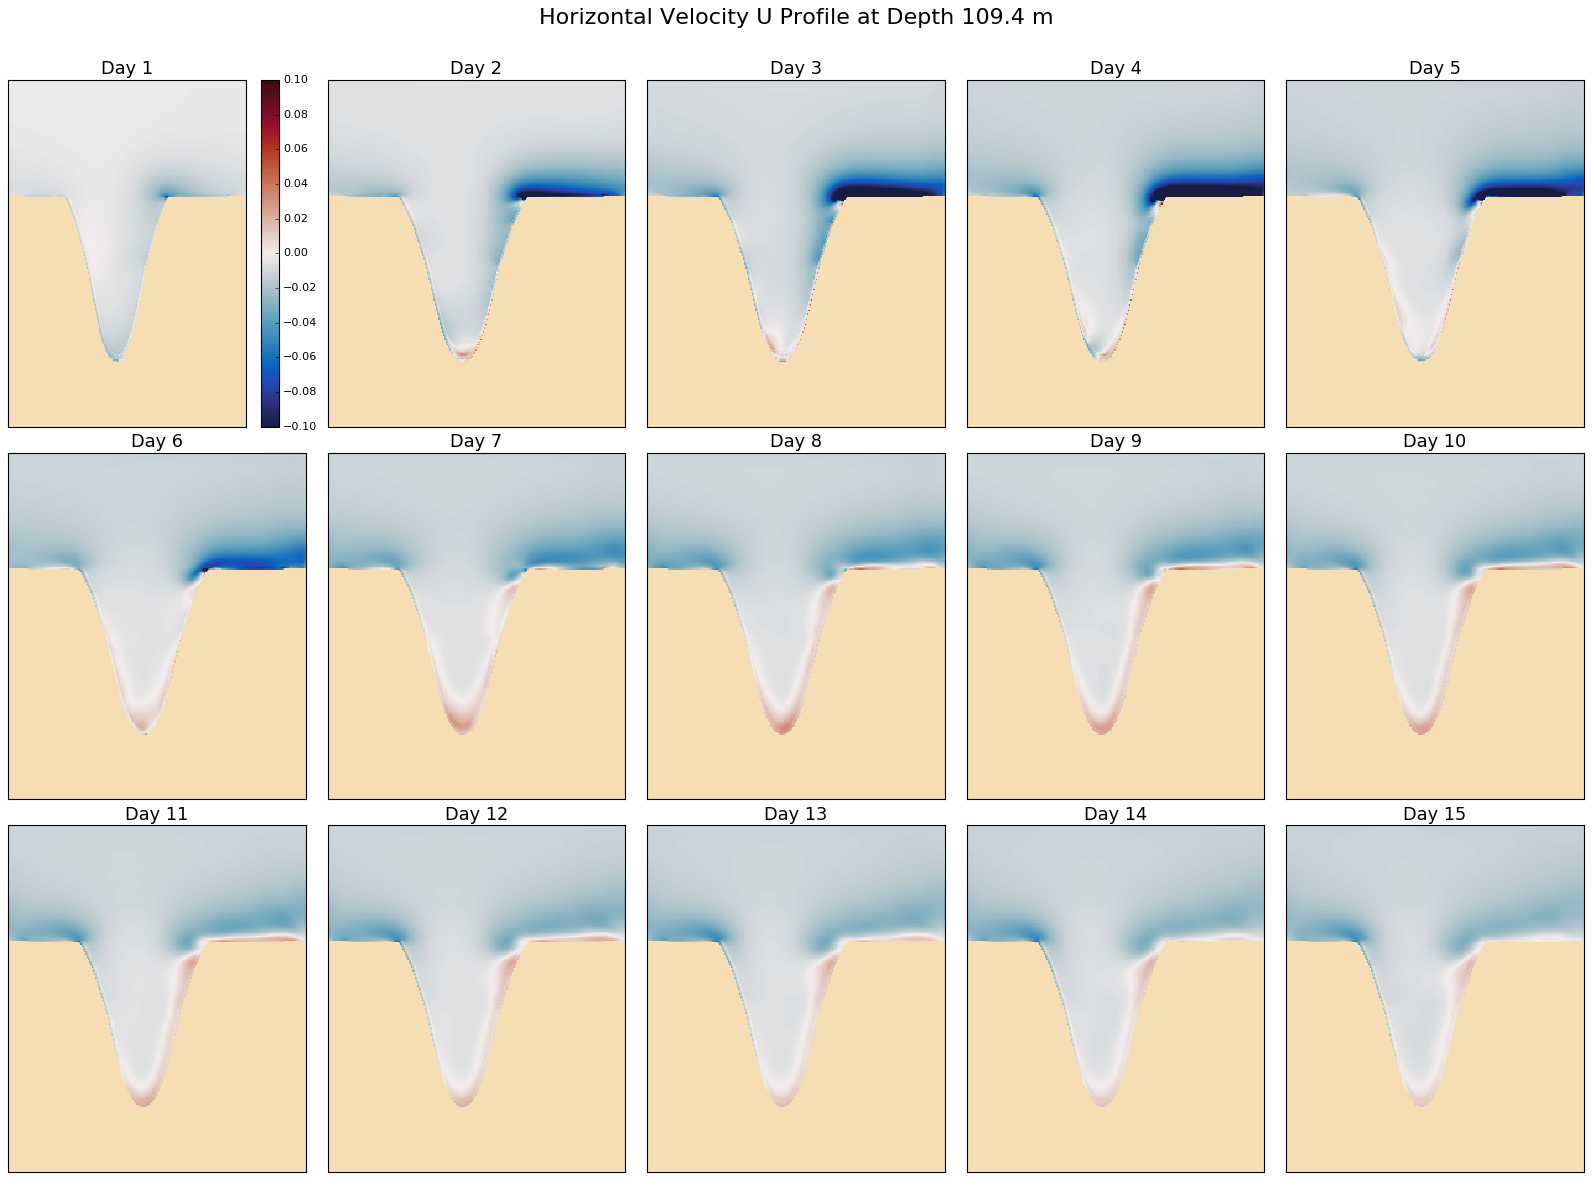

In [26]:
fig = plot_vel_snapshots(vozocrtxB, xs, ys, 0.1, 'Horizontal Velocity U')

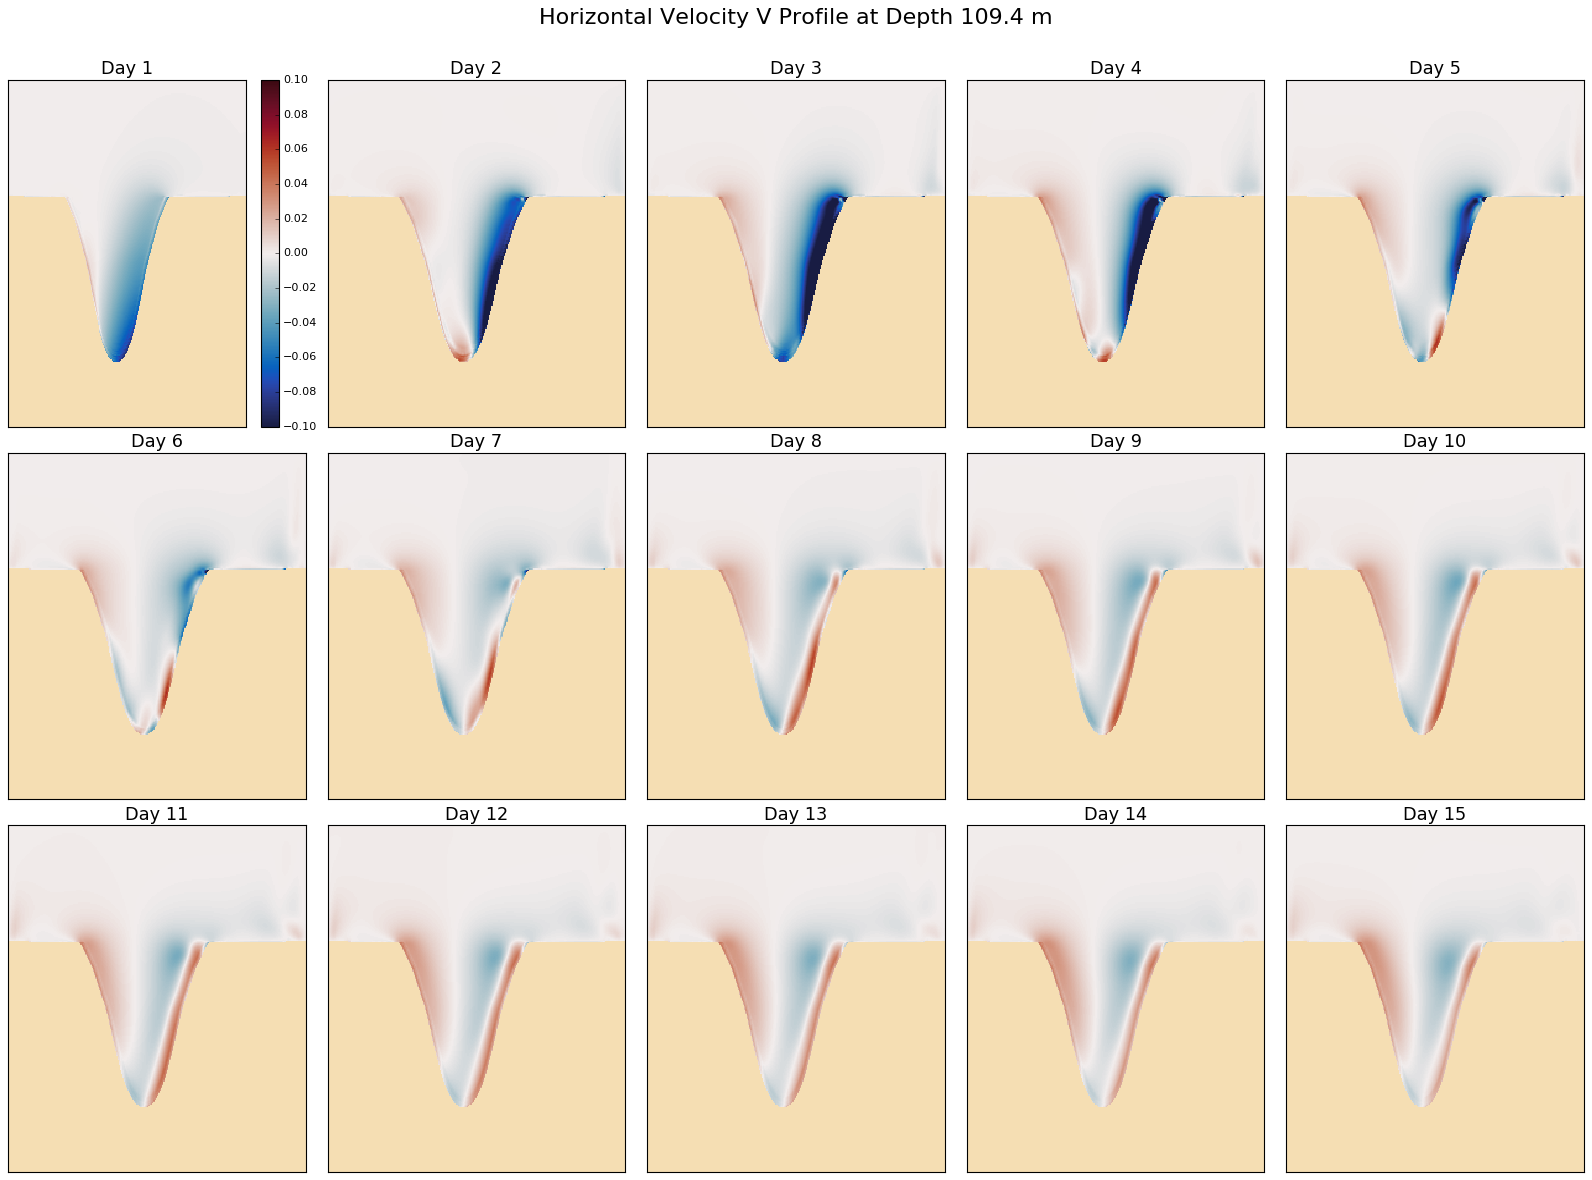

In [27]:
fig = plot_vel_snapshots(vomecrtyB, xs, ys, 0.1, 'Horizontal Velocity V')

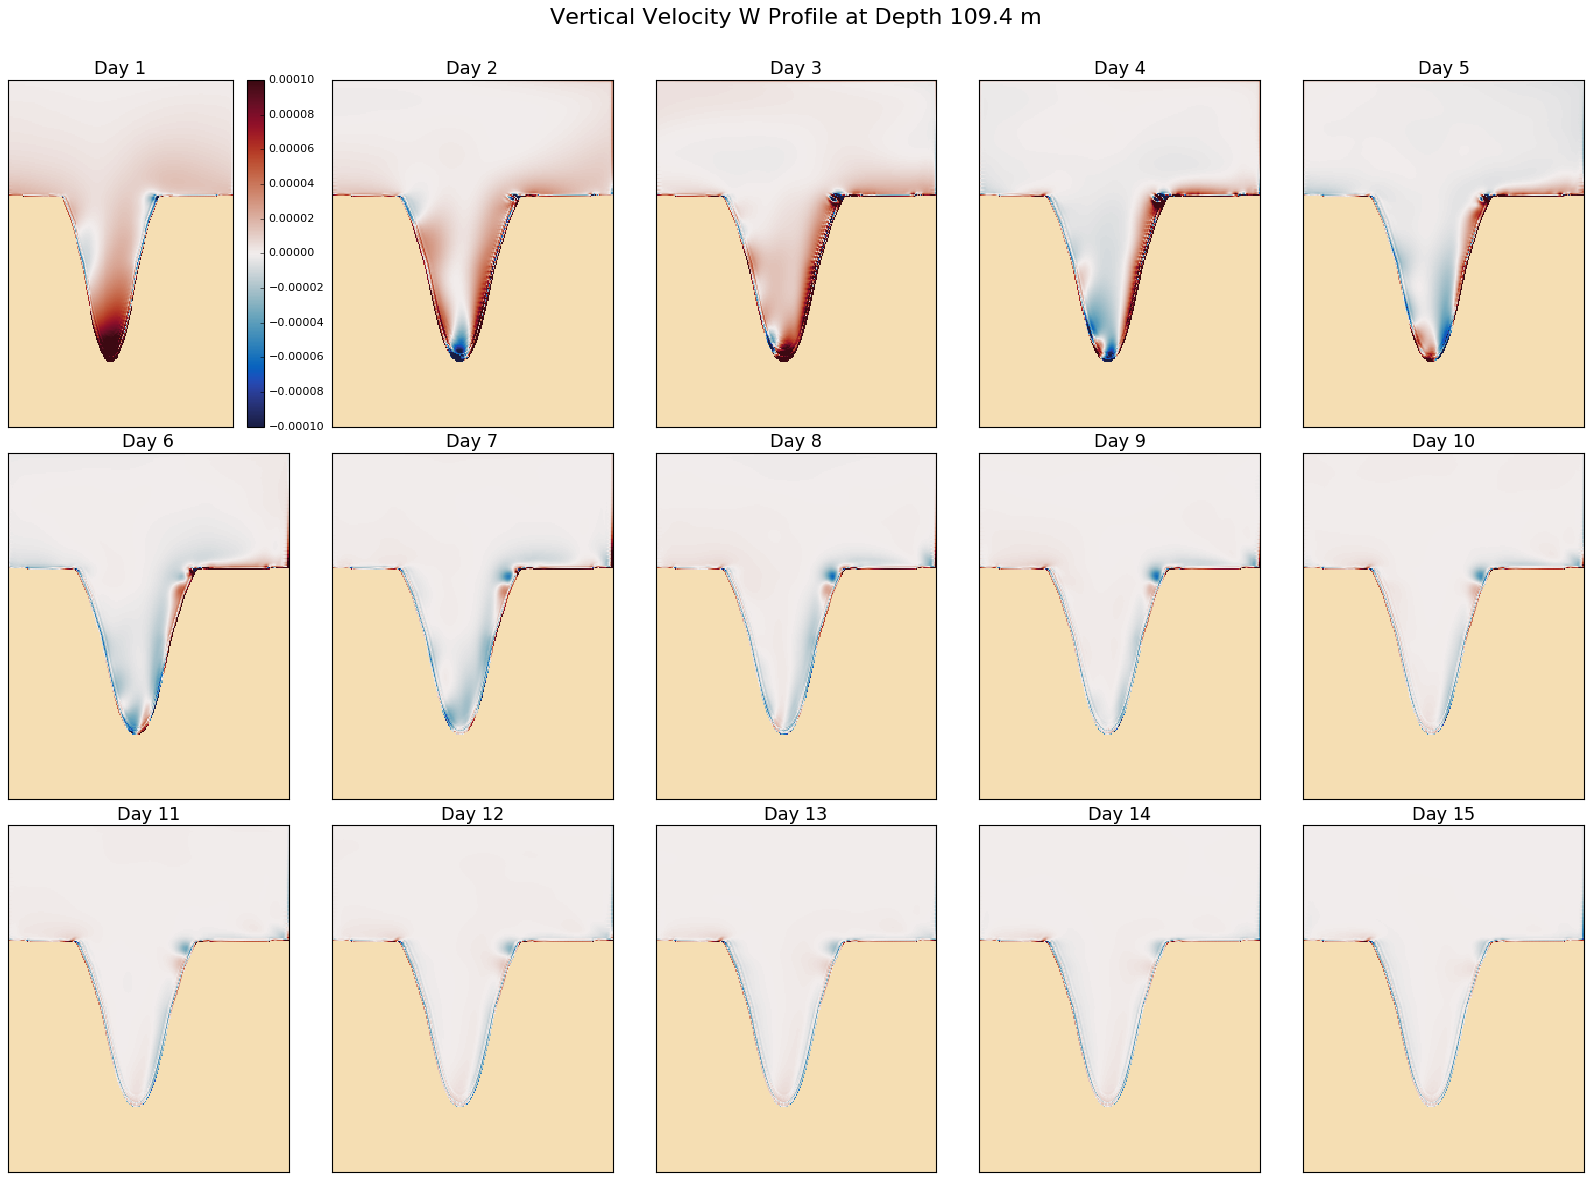

In [28]:
fig = plot_vel_snapshots(vovecrtzB, xs, ys, 0.0001, 'Vertical Velocity W')

# Third Depth

In [20]:
dep_ind = dep_inds[2]
vozocrtxC, vomecrtyC, vovecrtzC, umask, vmask, tmask, depthu = vel_timeseries(dirname, fname, dep_ind)
xs = np.arange(vozocrtxC.shape[-1])
ys = np.arange(vozocrtxC.shape[-2])

files
U
V
W


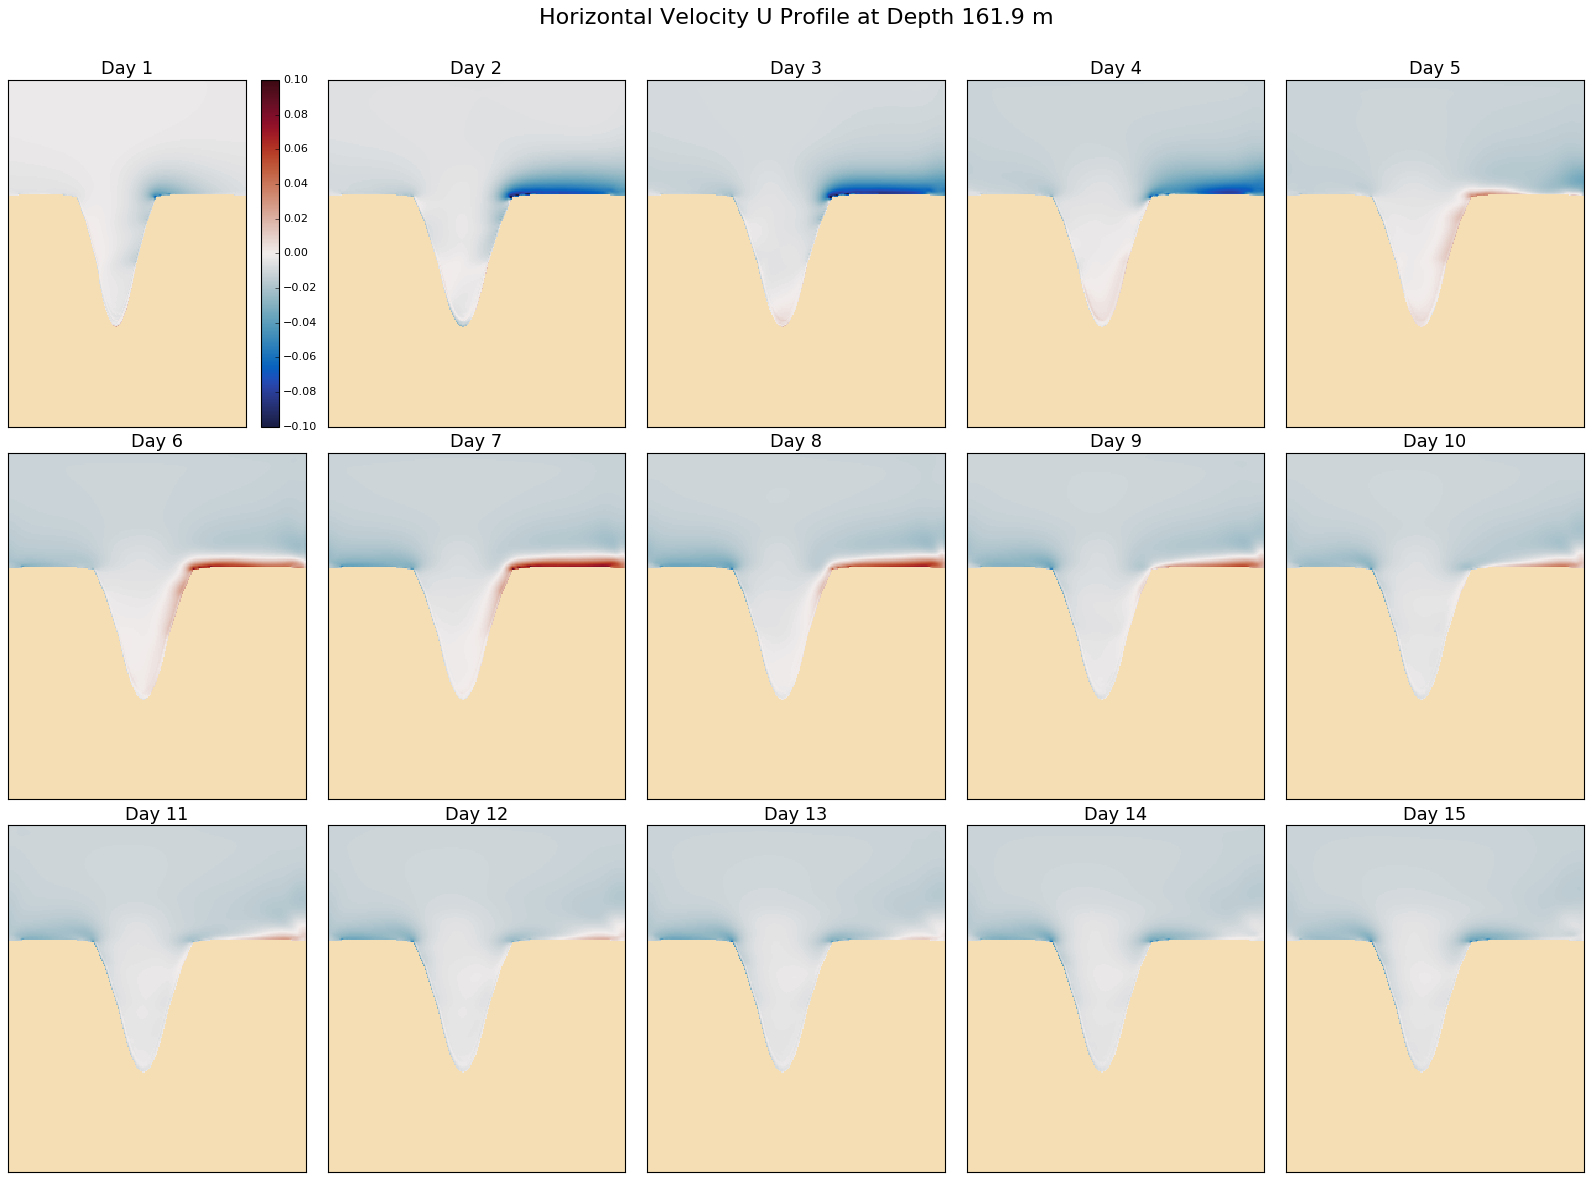

In [21]:
fig = plot_vel_snapshots(vozocrtxC, xs, ys, 0.1, 'Horizontal Velocity U')

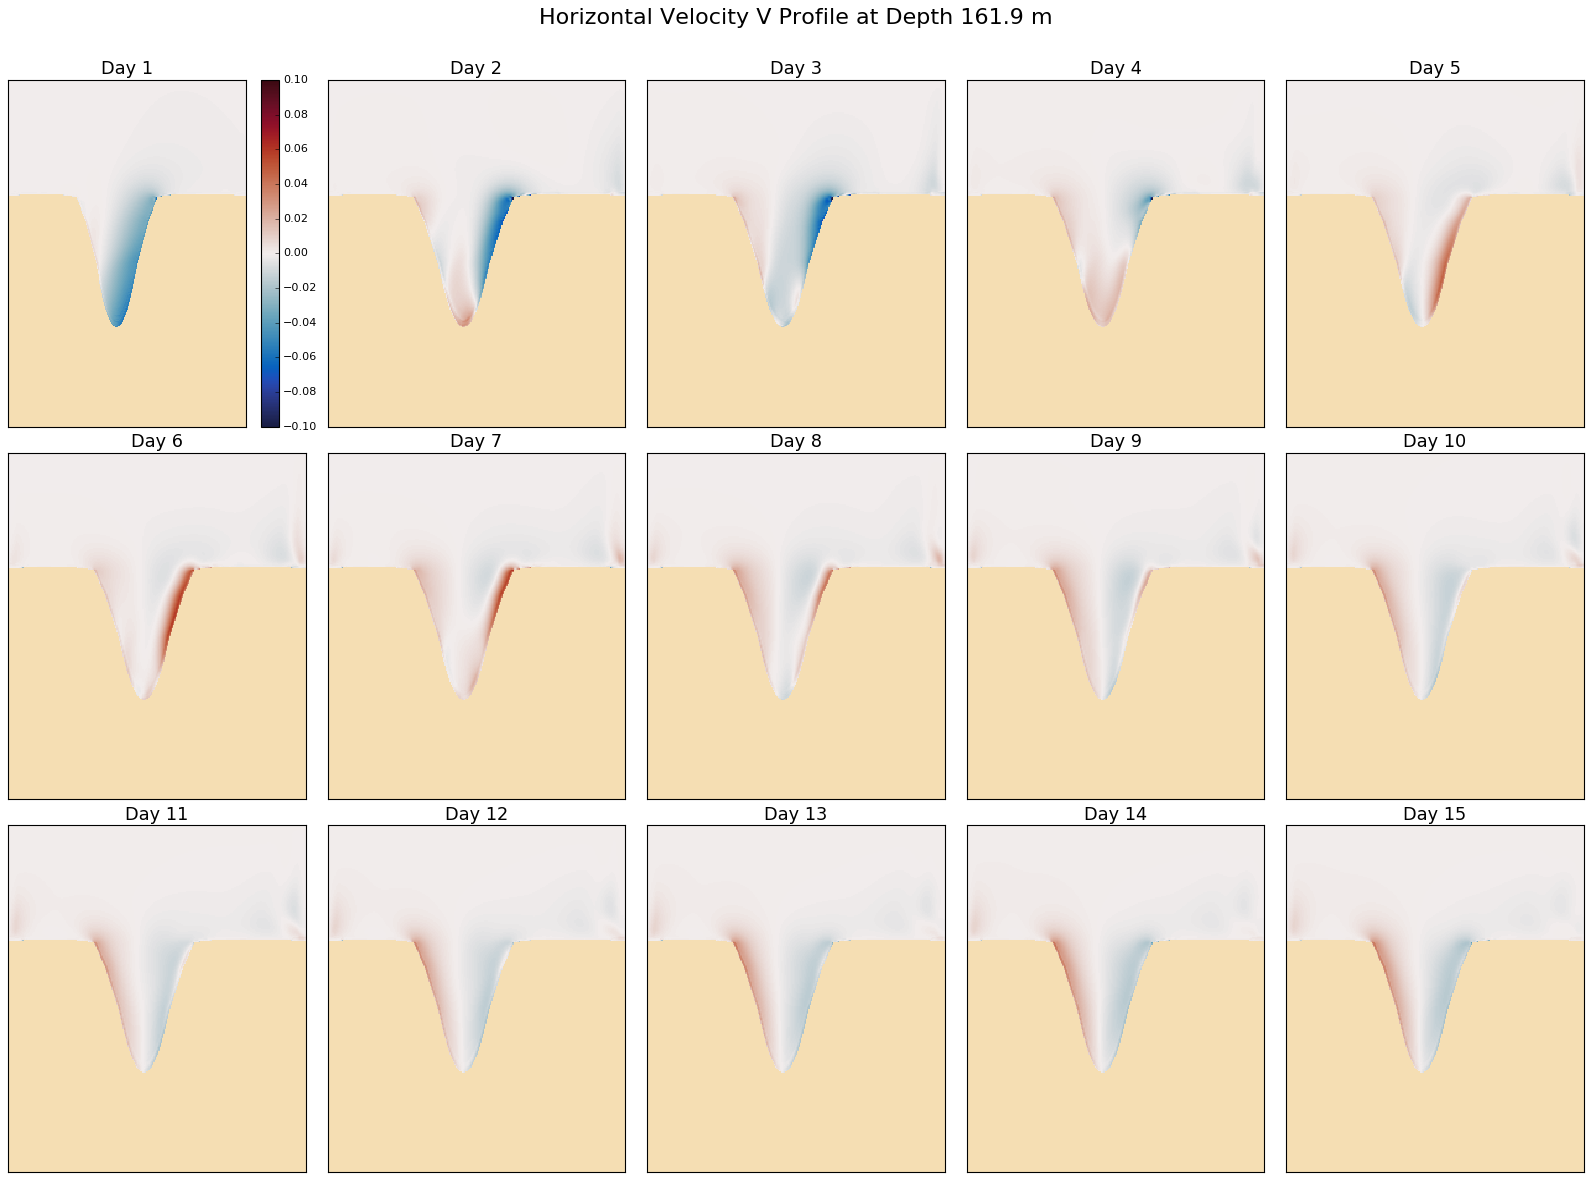

In [22]:
fig = plot_vel_snapshots(vomecrtyC, xs, ys, 0.1, 'Horizontal Velocity V')

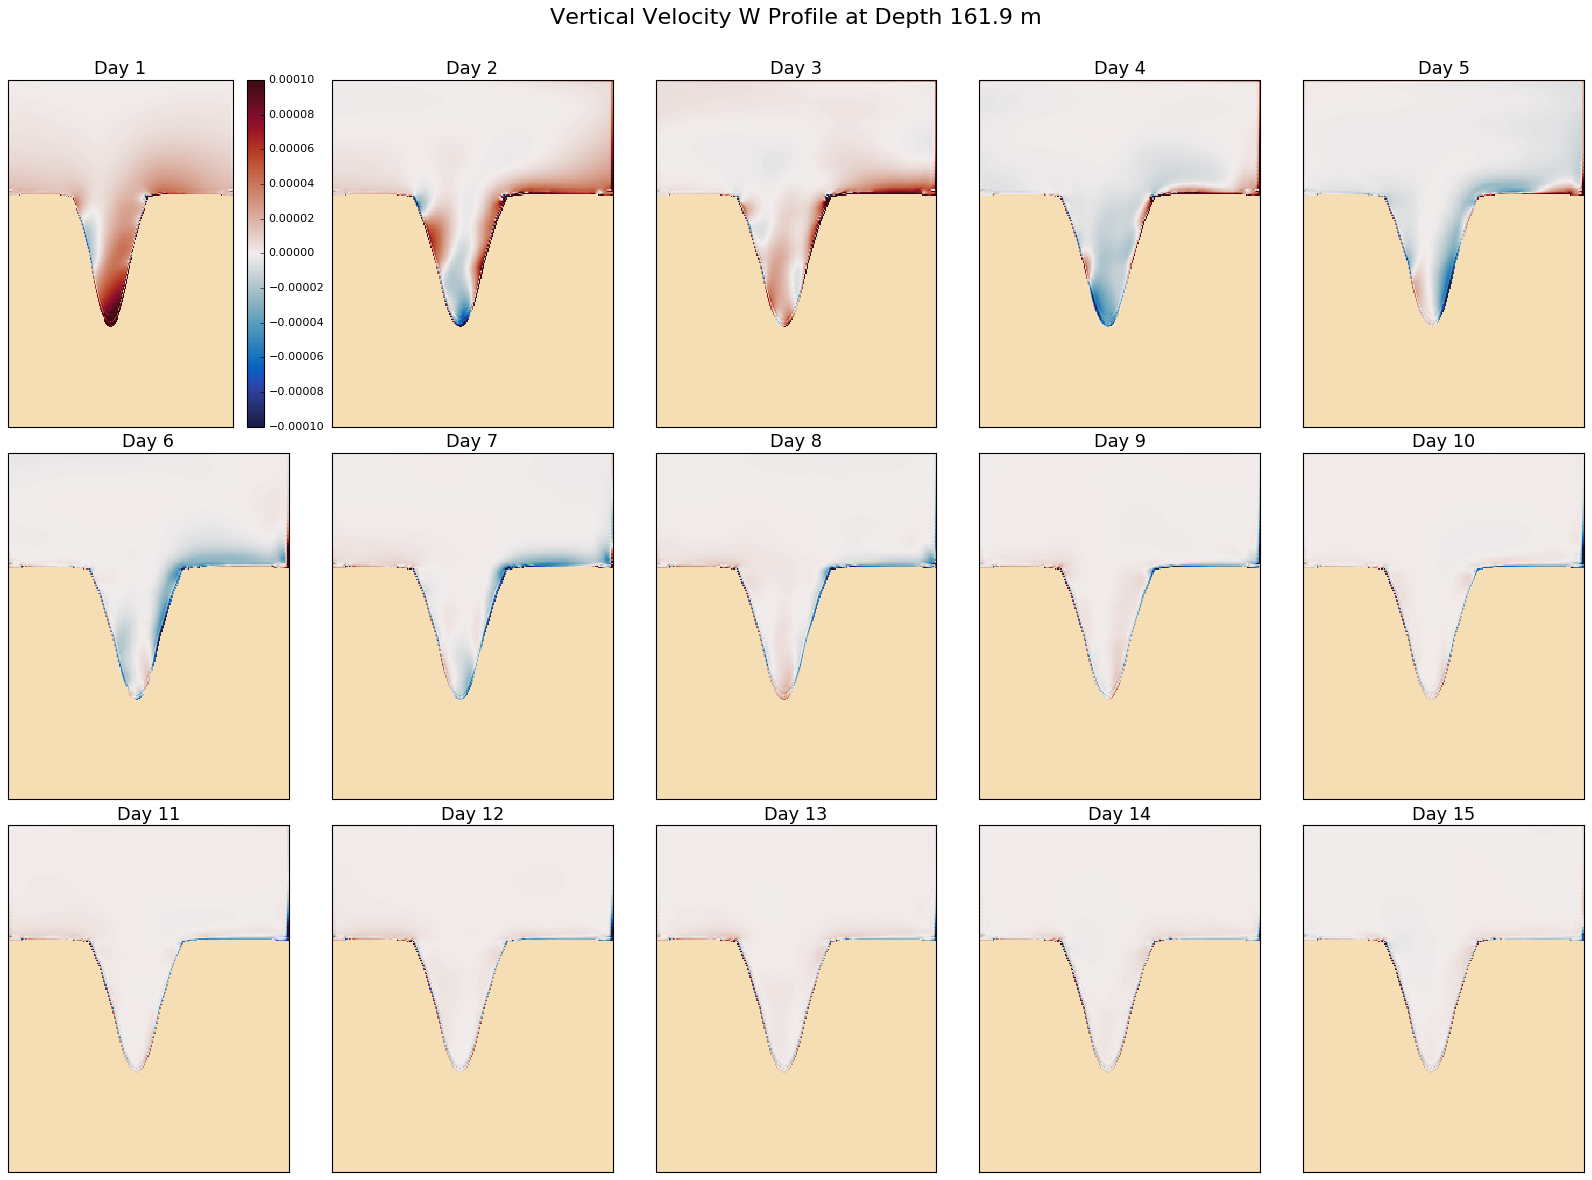

In [23]:
fig = plot_vel_snapshots(vovecrtzC, xs, ys, 0.0001, 'Vertical Velocity W')